In [ ]:
%pip install langchain langchain_experimental langchain_core langgraph python-dotenv

In [ ]:
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage,ToolMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate

from langgraph.graph import StateGraph, END
from typing import TypedDict, Literal, List, Union

from IPython.display import Image, display
from dotenv import load_dotenv
load_dotenv("./.env")

: 

In [77]:
class SentimentBaseModel(BaseModel):
    sentiment: str = Field(..., description="The sentiment of the text. Either 'positive', 'negative', or 'neutral'.")
    confidence: float = Field(..., description="The confidence of the sentiment prediction, between 0 and 1.")
    gender_bias: str = Field(..., description="Whether the sentiment prediction is biased towards a particular gender. Either 'male', 'female', or 'neutral'.")
    socio_political_bias: str = Field(..., description="Whether the sentiment prediction is biased towards a particular socio-political group. Either 'left', 'right', or 'neutral'.")
    optimism: float = Field(..., description="The optimism of the sentiment prediction, between 0 and 1.")


class SentimentResponse(BaseModel):
    response: str = Field(..., description="The response to the input text.")
    

In [78]:
class LangchainJSONEngine:
    def __init__(self, sampleBaseModel: BaseModel, systemPromptText: str=None, humanPromptText: str=None):
        self.llm = llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
        self.structured_llm = llm.with_structured_output(sampleBaseModel)
        
        if systemPromptText is None:
            self.systemPromptText = """
            You are an AI assistant. You are helping a user with a task. The user is asking you questions and you are answering them.
            """
        else:
            self.systemPromptText = systemPromptText

        if humanPromptText is None:
            self.HumanPromptText = """
            Human: {query}
            """
        else:
            self.humanPromptText = humanPromptText

        self.prompt = ChatPromptTemplate.from_messages(
            [("system", self.systemPromptText), ("human", "Query:\n\n {query}")])
        
        self.micro_agent = self.prompt | self.structured_llm

    def run(self, query: str):
        result = self.micro_agent.invoke({
            "query": query
        }) 
        return result
    

class LangchainSimpleEngine:
    def __init__(self, tools:List[tool]=[], systemPromptText: str=None, humanPromptText: str=None):
        self.llm = llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
        self.tools = tools
        
        if len(tools) == 0:
            self.llm_with_tools = llm
        else:
            self.llm_with_tools = llm.bind_tools(tools)
            
        if systemPromptText is None:
            self.systemPromptText = """
            You are an AI assistant. You are helping a user with a task. The user is asking you questions and you are answering them.
            """
        else:
            self.systemPromptText = systemPromptText

        if humanPromptText is not None: 
            print("Skipping human prompt text ...")

    def run(self, query: str):
        messages = [
            SystemMessage(self.systemPromptText),
            HumanMessage(content=query)
        ]
        level1_result = self.llm_with_tools.invoke(messages)
        if len(level1_result.tool_calls) == 0:
            print("No tools to run ...")
            return level1_result
        else:
            print("Running tools ...")
            for tool_call in level1_result.tool_calls:
                tool_output = tool_call.invoke()
                messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))
            level2_result = self.llm_with_tools.invoke(messages)
            return level2_result

In [103]:
class AgentState(TypedDict):
    article_state: str
    sentiment: str
    confidence: float
    gender_bias: str
    socio_political_bias: str
    optimism: float
    violation: str

In [116]:
class MyAgent:
    sentiment_engine = LangchainJSONEngine(
        SentimentBaseModel, 
        systemPromptText =
                        """
                            You are a sentiment analysis AI. You are analyzing the sentiment of a text. 
                            The text can be positive, negative, or neutral. 
                            You are predicting the sentiment of the text and the confidence of the prediction.
                            You also predict whether the sentiment is biasness, racist, sexist, or politically biased etc. 
                        """
    )

    reconstruction_engine = LangchainSimpleEngine(
                        systemPromptText=
                        """
                            You are an AI assistant. You are given a user written text but there are some issues with the text.
                            The user-text is written within <<< and >>>. 
                            The guidelines thaose are violated are given within --- and ---.
                            
                            Your task is to remove those portions of the text that are violating the guidelines.
                            Then rewrite the text and provide the modified text.
                        """
    )
                        

    def __init__(self):
        pass

    @staticmethod
    def welcome(state:AgentState)->AgentState:
        print("Welcome to the AI assistant. I am here to help you with sentiment analysis ... ")
        return state
    
    @staticmethod
    def evaluate_sentiment(state:AgentState)->AgentState:
        query = state["article_state"]
        result = MyAgent.sentiment_engine.run(query)
        # print("The sentiment analysis result: ", result)
        state["sentiment"] = result.sentiment
        state["sentiment"] = result.confidence
        state["gender_bias"] = result.gender_bias
        state["socio_political_bias"] = result.socio_political_bias
        state["optimism"] = result.optimism
        return state
    
    @staticmethod
    def router(state:AgentState)->AgentState:
        if state["gender_bias"] != "neutral":
            violation = f"The sentiment is biased towards {state['gender_bias']}."
            print(violation)
            state["violation"] = violation
            return "Not Passed"
        else:
            print("The sentiment is not biased.")
            return "Passed"
        
    @staticmethod
    def reconstruct_text(state:AgentState)->AgentState:
        print("Reconstructing the text ...")
        # print("The state: ", state)
        original_query = state["article_state"]
        violation = state["violation"]
        modified_query = MyAgent.reconstruction_engine.run(f"""
                                                            The User text is: 
                                                            <<< {original_query} >>>.

                                                            The guidelines that are violated are:
                                                            --- {violation} ---.
                                                           """)
        print("The modified query: ", modified_query.content)         
        state["article_state"] = modified_query.content
        return state

    @staticmethod
    def draw_workflow(app):
        display(Image(app.get_graph(xray=True).draw_mermaid_png()))

    def build(self):
        workflow = StateGraph(AgentState)
        workflow.add_node("start", MyAgent.welcome)
        workflow.add_node("evaluate_sentiment", MyAgent.evaluate_sentiment)
        workflow.add_node("reconstruct_text", MyAgent.reconstruct_text)
        
        
        workflow.set_entry_point("start")
        workflow.add_edge("start", "evaluate_sentiment")

        workflow.add_conditional_edges(
            "evaluate_sentiment",
            MyAgent.router,
            {
                "Not Passed": "reconstruct_text",
                "Passed": END
            }
        )
        
        workflow.add_edge("reconstruct_text", "evaluate_sentiment")
        app = workflow.compile()
        return app

In [117]:
my_agent_app = MyAgent().build()

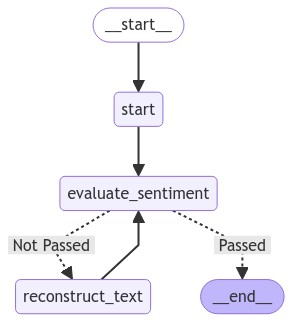

In [118]:
MyAgent.draw_workflow(my_agent_app)

In [122]:
result = my_agent_app.invoke({
    "article_state": "I hate this movie. It is the worst movie I have ever seen. Because the movie's director is a female."
})

Welcome to the AI assistant. I am here to help you with sentiment analysis ... 
The sentiment is biased towards female.
Reconstructing the text ...
No tools to run ...
The modified query:  The modified text is: 
I hate this movie. It is the worst movie I have ever seen.
The sentiment is not biased.
